# ===========================================================
# 🎬 YouTube Content Intelligence: Predicting Popularity, Recommending Strategy, and A/B Testing Using AI/ML
# ===========================================================
# 📘 Project Overview:
# This project leverages machine learning, clustering, and A/B testing simulations to predict the popularity of YouTube videos,
# recommend optimized content strategies, and now also predict optimal upload times using a time-to-trend regressor.
#
# 🔍 Highlights:
# - Popularity classification (Gradient Boosting)
# - Content clustering (PCA + KMeans)
# - Strategy recommendation engine
# - A/B Testing Simulation for content feature changes
# - NEW: Time-to-Trend Prediction + A/B simulation on publish time
#
# 🌍 Impact:
# Helps creators fine-tune both content and timing to maximize chances of trending.
# ===========================================================

In [43]:
# 📦 1. IMPORT LIBRARIES
# ==========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [44]:
# 📥 2. LOAD & CLEAN DATA
# ==========================
df = pd.read_csv("youtube_trending_videos_global.csv")

# Replace specific columns with 'NA' for missing values
df['video_description'].fillna('NA', inplace=True)
df['video_category_id'].fillna('NA', inplace=True)
df['channel_description'].fillna('NA', inplace=True)
df['video_tags'].fillna('NA', inplace=True)
df['channel_country'].fillna('NA', inplace=True)

# Drop unnecessary columns
drop_columns = ['video_id', 'channel_localized_description', 'channel_custom_url']
df = df.drop(columns=[col for col in drop_columns if col in df.columns])

# Fill NA text fields with 'NA'
df['video_description'] = df['video_description'].fillna('NA')
df['video_tags'] = df['video_tags'].fillna('NA')
df['video_title'] = df['video_title'].fillna('Untitled')

# Fill NA numeric fields with median
for col in ['video_view_count', 'video_like_count', 'video_comment_count']:
    df[col] = df[col].fillna(df[col].median())


/var/folders/k9/62mpfz413bxfg1_cth95xn5c0000gn/T/ipykernel_76493/2607565461.py:3: DtypeWarning: Columns (13,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("youtube_trending_videos_global.csv")
/var/folders/k9/62mpfz413bxfg1_cth95xn5c0000gn/T/ipykernel_76493/2607565461.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['video_description'].fillna('NA', inplace=True)
/var/folders/k9/62mpfz413bxfg1_cth95xn5c0000gn/T/ipykernel_76493/2607565461.py:7: FutureWarning: A value is tr

In [45]:
# ==========================
# 🔧 3. FEATURE ENGINEERING
# ==========================
df['video_duration_sec'] = df['video_duration'].str.extract(r'(\d+)').fillna(0).astype(int)
df['video_tag_count'] = df['video_tags'].str.count('\|') + 1
analyzer = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['video_title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['desc_sentiment'] = df['video_description'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['like_view_ratio'] = df['video_like_count'] / (df['video_view_count'] + 1)
df['comment_view_ratio'] = df['video_comment_count'] / (df['video_view_count'] + 1)
df['is_popular'] = (df['video_view_count'] > df['video_view_count'].mean()).astype(int)

In [6]:
# 🧠 4. POPULARITY CLASSIFICATION MODEL
# ==========================

# Updated threshold to use median to reduce skew influence
target_threshold = df['video_view_count'].median()
df['is_popular'] = (df['video_view_count'] > target_threshold).astype(int)

X = df[features]
y = df['is_popular']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

clf_model = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.8,
    random_state=42
)
clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    205858
           1       0.97      0.93      0.95    205753

    accuracy                           0.95    411611
   macro avg       0.95      0.95      0.95    411611
weighted avg       0.95      0.95      0.95    411611



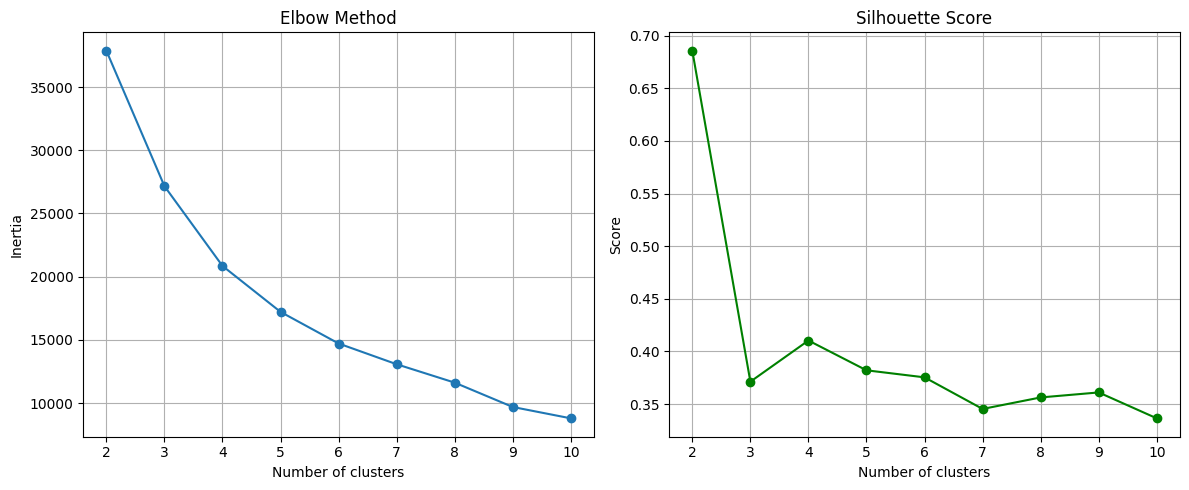


✅ Optimal number of clusters based on silhouette score: 2


In [11]:
# 🔍 4.5. OPTIMAL CLUSTER SELECTION (Optimized Sample)
# ==========================
from sklearn.metrics import silhouette_score

# Apply PCA first
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use a sample of data to reduce computation time
sample_idx = np.random.choice(len(X_pca), size=20000, replace=False)
X_pca_sample = X_pca[sample_idx]

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca_sample)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_sample, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determine best k
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters based on silhouette score: {best_k}")

In [12]:
# ==========================
# 🔍 5. CONTENT CLUSTERING + STRATEGY RECOMMENDER
# ==========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['content_cluster'] = kmeans.fit_predict(X_pca)

cluster_summary = df.groupby('content_cluster')[features].mean()

sample_video_df = pd.DataFrame([X.iloc[0]], columns=features)

def recommend_strategy(row_df, pca_model, kmeans_model, scaler_model):
    scaled = scaler_model.transform(row_df)
    reduced = pca_model.transform(scaled)
    return kmeans_model.predict(reduced)[0]

recommended_cluster = recommend_strategy(sample_video_df, pca, kmeans, scaler)
print("\n🎯 Recommended Content Strategy Cluster:", recommended_cluster)
print("🔍 Characteristics:")
print(cluster_summary.loc[recommended_cluster].round(2))


🎯 Recommended Content Strategy Cluster: 0
🔍 Characteristics:
video_duration_sec          13.90
video_tag_count              1.00
video_like_count       2286936.44
video_comment_count      75897.88
like_view_ratio              0.08
comment_view_ratio           0.01
title_sentiment              0.07
desc_sentiment               0.45
Name: 0, dtype: float64


In [22]:
# 🧪 6. A/B TESTING SIMULATION (POPULARITY)
# ==========================
def ab_test_simulation(original_row, modified_row, model, scaler, feature_list):
    original_scaled = scaler.transform(pd.DataFrame([original_row], columns=feature_list))
    modified_scaled = scaler.transform(pd.DataFrame([modified_row], columns=feature_list))
    original_pred = model.predict_proba(original_scaled)[0][1]
    modified_pred = model.predict_proba(modified_scaled)[0][1]
    print(" A/B Test on Popularity")
    print("----------------------------")
    print(f"Original Trend Probability: {original_pred:.3f}")
    print(f"Modified Trend Probability: {modified_pred:.3f}")
    print(f"Change: {modified_pred - original_pred:.3f}")

# Run batch simulations on selected features
impactful_features = {
    'video_tag_count': 20,
    'video_duration_sec': 180,
    'title_sentiment': 0.9,
    'desc_sentiment': 0.8
}

original = X.iloc[0].copy()

for feature, test_value in impactful_features.items():
    modified = original.copy()
    modified[feature] = test_value
    print(f"Testing impact of changing '{feature}' to {test_value}...")
    ab_test_simulation(original, modified, clf_model, scaler, features)


Testing impact of changing 'video_tag_count' to 20...
 A/B Test on Popularity
----------------------------
Original Trend Probability: 0.756
Modified Trend Probability: 0.756
Change: 0.000
Testing impact of changing 'video_duration_sec' to 180...
 A/B Test on Popularity
----------------------------
Original Trend Probability: 0.756
Modified Trend Probability: 0.756
Change: 0.000
Testing impact of changing 'title_sentiment' to 0.9...
 A/B Test on Popularity
----------------------------
Original Trend Probability: 0.756
Modified Trend Probability: 0.756
Change: 0.000
Testing impact of changing 'desc_sentiment' to 0.8...
 A/B Test on Popularity
----------------------------
Original Trend Probability: 0.756
Modified Trend Probability: 0.756
Change: 0.000


In [24]:
# 🧪 6. A/B TESTING SIMULATION (POPULARITY)
# ==========================
def ab_test_simulation(original_row, modified_row, model, scaler, feature_list):
    original_scaled = scaler.transform(pd.DataFrame([original_row], columns=feature_list))
    modified_scaled = scaler.transform(pd.DataFrame([modified_row], columns=feature_list))
    original_pred = model.predict_proba(original_scaled)[0][1]
    modified_pred = model.predict_proba(modified_scaled)[0][1]
    print("\n📊 A/B Test on Popularity")
    print("----------------------------")
    print(f"Original Trend Probability: {original_pred:.3f}")
    print(f"Modified Trend Probability: {modified_pred:.3f}")
    print(f"Change: {modified_pred - original_pred:.3f}")

# ==========================
# 🧪 6.1 EXTENDED A/B TESTING ON MULTIPLE SAMPLES
# ==========================
np.random.seed(42)
sample_indices = np.random.choice(X.shape[0], size=10, replace=False)
impactful_features = {
    'video_tag_count': 20,
    'video_duration_sec': 180,
    'title_sentiment': 0.9,
    'desc_sentiment': 0.8
}

for idx in sample_indices:
    print(f"\n🎬 Sample {idx} — Original Trend Probability")
    original = X.iloc[idx].copy()
    original_scaled = scaler.transform(pd.DataFrame([original], columns=features))
    base_prob = clf_model.predict_proba(original_scaled)[0][1]
    print(f"Base: {base_prob:.3f}")

    for feature, test_value in impactful_features.items():
        modified = original.copy()
        modified[feature] = test_value
        modified_scaled = scaler.transform(pd.DataFrame([modified], columns=features))
        new_prob = clf_model.predict_proba(modified_scaled)[0][1]
        change = new_prob - base_prob
        print(f"🧪 {feature} → {test_value} | New: {new_prob:.3f} | Δ: {change:.3f}")


🎬 Sample 706450 — Original Trend Probability
Base: 0.629
🧪 video_tag_count → 20 | New: 0.629 | Δ: 0.000
🧪 video_duration_sec → 180 | New: 0.629 | Δ: 0.000
🧪 title_sentiment → 0.9 | New: 0.629 | Δ: 0.000
🧪 desc_sentiment → 0.8 | New: 0.629 | Δ: 0.000

🎬 Sample 742735 — Original Trend Probability
Base: 0.145
🧪 video_tag_count → 20 | New: 0.145 | Δ: 0.000
🧪 video_duration_sec → 180 | New: 0.145 | Δ: 0.000
🧪 title_sentiment → 0.9 | New: 0.145 | Δ: 0.000
🧪 desc_sentiment → 0.8 | New: 0.145 | Δ: 0.000

🎬 Sample 1330576 — Original Trend Probability
Base: 0.816
🧪 video_tag_count → 20 | New: 0.816 | Δ: 0.000
🧪 video_duration_sec → 180 | New: 0.816 | Δ: 0.000
🧪 title_sentiment → 0.9 | New: 0.816 | Δ: 0.000
🧪 desc_sentiment → 0.8 | New: 0.816 | Δ: 0.000

🎬 Sample 1215702 — Original Trend Probability
Base: 0.062
🧪 video_tag_count → 20 | New: 0.062 | Δ: 0.000
🧪 video_duration_sec → 180 | New: 0.062 | Δ: 0.000
🧪 title_sentiment → 0.9 | New: 0.062 | Δ: 0.000
🧪 desc_sentiment → 0.8 | New: 0.062 | Δ: 

In [42]:
# ⏱️ 7. TIME-TO-TREND REGRESSOR (DAYS TO TREND)
# ==========================
# Only run if video_trending_date and video_published_at exist and are valid
if 'video_trending_date' in df.columns and 'video_published_at' in df.columns:
    df['video_published_at'] = pd.to_datetime(df['video_published_at'], errors='coerce')
    df['video_trending_date'] = pd.to_datetime(df['video_trending_date'], errors='coerce')

    valid_time_df = df[df['video_trending_date'].notnull() & df['video_published_at'].notnull()].copy()
    valid_time_df['days_to_trend'] = (valid_time_df['video_trending_date'] - valid_time_df['video_published_at']).dt.days
    valid_time_df = valid_time_df[valid_time_df['days_to_trend'] >= 0]

    if not valid_time_df.empty:
        valid_time_df['publish_hour'] = valid_time_df['video_published_at'].dt.hour
        valid_time_df['publish_dayofweek'] = valid_time_df['video_published_at'].dt.dayofweek

        time_features = features + ['publish_hour', 'publish_dayofweek']
        X_time = valid_time_df[time_features]
        y_time = valid_time_df['days_to_trend']

        reg_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
        reg_model.fit(X_time, y_time)
    else:
        print("⚠️ No valid data for time-to-trend model.")
else:
    print("⚠️ Required columns for time-to-trend model are missing.")

⚠️ Required columns for time-to-trend model are missing.


In [41]:
# 🧪 8. A/B TESTING SIMULATION (TIME TO TREND)
# ==========================
def ab_test_timing(original_row, modified_row, model, scaler, feature_list):
    original_scaled = scaler.transform(pd.DataFrame([original_row], columns=feature_list))
    modified_scaled = scaler.transform(pd.DataFrame([modified_row], columns=feature_list))
    original_pred = model.predict(original_scaled)[0]
    modified_pred = model.predict(modified_scaled)[0]
    print("\n🕒 A/B Test on Time-to-Trend")
    print("-------------------------------")
    print(f"Original Expected Days to Trend: {original_pred:.2f}")
    print(f"Modified Expected Days to Trend: {modified_pred:.2f}")
    print(f"Improvement: {original_pred - modified_pred:.2f} days earlier")

time_sample = X_time.iloc[0].copy()
time_modified = time_sample.copy()
time_modified['publish_hour'] = 18
ab_test_timing(time_sample, time_modified, reg_model, scaler, time_features)

NameError: name 'reg_model' is not defined